<a href="https://colab.research.google.com/github/ShikhaSahu/Machine_Translation/blob/master/c1_update1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%matplotlib inline

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
import xlrd
loc ='/content/drive/My Drive/data_set1 - Copy_less.xlsx'
workbook = xlrd.open_workbook(loc)
worksheet = workbook.sheet_by_name("Sheet1")
num_rows = worksheet.nrows #Number of Rows
num_cols = worksheet.ncols #Number of Columns
f = open("text_data_file_en_hn1.txt","+w")
for curr_row in range(0, num_rows, 1):
 
 for curr_col in range(0, num_cols-1, 1):
  data = worksheet.cell_value(curr_row, curr_col) # Read the data in the current cell
  f.write(data)
  if curr_col == 0:
    f.write('\t')
  else:
    f.write("\n")



f.close()

In [0]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [0]:
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = s.lower().strip()
    #s = re.sub(r"([.!?])", r" \1", s)
    #table = str.maketrans('', '', string.punctuation)
    #s = [word.translate(table) for word in s]
    s = re.sub(r'[.!?]','', s)
    return s

In [0]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('/content/text_data_file_en_hn1.txt',encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    '''pairs=[]
    for l in lines:
      p=[]
      for s in l.split('\t'):
        p.append(normalizeString(s))
      pairs.append(p)'''

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [0]:
MAX_LENGTH = 22

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
  #print(p)
  return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH #and \
        #p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    l=[pair for pair in pairs if filterPair(pair)]
    print(l)
    return l

In [10]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    for pair in range(20):
      print(pairs[pair][0],len(pairs[pair][0].split(' ')),pairs[pair][0].split(' '),pairs[pair][1],len(pairs[pair][1].split(' ')),pairs[pair][1].split(' '))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'hin1', False)
print(random.choice(pairs))
#print(pairs)

Reading lines...
Read 2795 sentence pairs
wow 1 ['wow'] वाह 1 ['वाह']
help 1 ['help'] बचाओ 1 ['बचाओ']
jump 1 ['jump'] उछलो 1 ['उछलो']
jump 1 ['jump'] कूदो 1 ['कूदो']
jump 1 ['jump'] छलांग 1 ['छलांग']
hello 1 ['hello'] नमस्ते। 1 ['नमस्ते।']
hello 1 ['hello'] नमस्कार। 1 ['नमस्कार।']
cheers 1 ['cheers'] वाह-वाह 1 ['वाह-वाह']
cheers 1 ['cheers'] चियर्स 1 ['चियर्स']
got it 2 ['got', 'it'] समझे कि नहीं 3 ['समझे', 'कि', 'नहीं']
i'm ok 2 ["i'm", 'ok'] मैं ठीक हूँ। 3 ['मैं', 'ठीक', 'हूँ।']
awesome 1 ['awesome'] बहुत बढ़िया 2 ['बहुत', 'बढ़िया']
come in 2 ['come', 'in'] अंदर आ जाओ। 3 ['अंदर', 'आ', 'जाओ।']
get out 2 ['get', 'out'] बाहर निकल जाओ 3 ['बाहर', 'निकल', 'जाओ']
go away 2 ['go', 'away'] चले जाओ 2 ['चले', 'जाओ']
goodbye 1 ['goodbye'] ख़ुदा हाफ़िज़। 2 ['ख़ुदा', 'हाफ़िज़।']
perfect 1 ['perfect'] उत्तम 1 ['उत्तम']
perfect 1 ['perfect'] सही 1 ['सही']
welcome 1 ['welcome'] आपका स्वागत है। 3 ['आपका', 'स्वागत', 'है।']
welcome 1 ['welcome'] स्वागतम्। 1 ['स्वागतम्।']
[['wow', 'वाह'], ['help', 'बचाओ'

In [0]:
%matplotlib inline
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
%matplotlib inline
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
%matplotlib inline
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
def indexesFromSentence(lang, sentence):
    get_ipython().magic('matplotlib inline')
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [0]:
%matplotlib inline
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    %matplotlib inline

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
%matplotlib inline
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
%matplotlib inline
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    %matplotlib inline
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    %matplotlib inline
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    %matplotlib inline
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [0]:
def evaluateRandomly(encoder, decoder, n=10):
    from nltk.translate.bleu_score import sentence_bleu
    %matplotlib inline
    for i in range(n):
        pair = random.choice(pairs)
        print('English: ', pair[0])
        print('Actual: ', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('Predicted: ', output_sentence)
        act = pair[1].split()
        pred = output_sentence.split()
        print('Cumulative 1-gram: %f' % sentence_bleu([act], pred, weights=(1, 0, 0, 0)))
        print('Cumulative 2-gram: %f' % sentence_bleu([act], pred, weights=(0.5, 0.5, 0, 0)))
        print('Cumulative 3-gram: %f' % sentence_bleu([act], pred, weights=(0.33, 0.33, 0.33, 0)))
        print('Cumulative 4-gram: %f' % sentence_bleu([act], pred, weights=(0.25, 0.25, 0.25, 0.25)))
        score = sentence_bleu([act], pred)
        print(score)
        print('')

0m 5s (- 1m 40s) (200 5%) 4.9007
0m 8s (- 1m 18s) (400 10%) 5.0208
0m 12s (- 1m 8s) (600 15%) 4.9082
0m 15s (- 1m 2s) (800 20%) 5.1184
0m 19s (- 0m 57s) (1000 25%) 4.9656
0m 22s (- 0m 52s) (1200 30%) 4.8665
0m 26s (- 0m 48s) (1400 35%) 5.1914
0m 29s (- 0m 44s) (1600 40%) 5.0819
0m 33s (- 0m 40s) (1800 45%) 5.0059
0m 36s (- 0m 36s) (2000 50%) 4.8914
0m 40s (- 0m 33s) (2200 55%) 4.9087
0m 44s (- 0m 29s) (2400 60%) 4.8518
0m 47s (- 0m 25s) (2600 65%) 4.7554
0m 50s (- 0m 21s) (2800 70%) 4.8249
0m 54s (- 0m 18s) (3000 75%) 4.7830
0m 57s (- 0m 14s) (3200 80%) 4.6323
1m 1s (- 0m 10s) (3400 85%) 4.6591
1m 4s (- 0m 7s) (3600 90%) 4.7117
1m 8s (- 0m 3s) (3800 95%) 4.7183
1m 11s (- 0m 0s) (4000 100%) 4.6819


<Figure size 432x288 with 0 Axes>

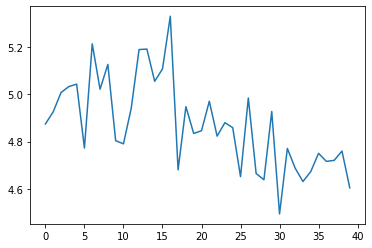

In [43]:
%matplotlib inline
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 4000, print_every=200)

In [44]:
%matplotlib inline
evaluateRandomly(encoder1, attn_decoder1)

English:  as soon as he finished his work, he went home
Actual:  वह अपना काम खतम करते ही घर चला गया।
Predicted:  वह अपने से बहुत है। 
Cumulative 1-gram: 0.089866
Cumulative 2-gram: 0.200946
Cumulative 3-gram: 0.264183
Cumulative 4-gram: 0.300484
0.3004843884984905

English:  these trees were planted by them
Actual:  ये पेड़ उन्होंने लगाए थे।
Predicted:  मेरे पास में में में में 
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
0

English:  i will try
Actual:  मैं कोशिश करूँगा।
Predicted:  मैं मैं नहीं हूँ। 
Cumulative 1-gram: 0.250000
Cumulative 2-gram: 0.500000
Cumulative 3-gram: 0.632878
Cumulative 4-gram: 0.707107
0.7071067811865476

English:  she always wears black
Actual:  वह हमेशा काले कपड़े पहनती है।
Predicted:  वह बहुत में में 
Cumulative 1-gram: 0.151633
Cumulative 2-gram: 0.303265
Cumulative 3-gram: 0.383860
Cumulative 4-gram: 0.428882
0.42888194248035344

English:  nobody came
Actual:  कोई नहीं आया।
Predicted:  व

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [45]:
%matplotlib inline
output_words, attentions = evaluate(encoder1, attn_decoder1, "did you do your ")
plt.matshow(attentions.numpy())

KeyError: ignored

input = have fun
output = तुम पास में में 


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2369 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2350 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2346 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2366 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2360 missing from current font.
  font.set_text(s

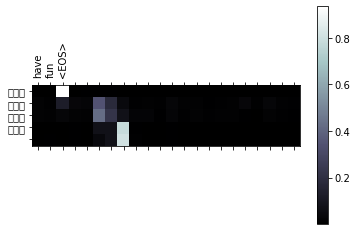

input = i like studying english
output = मैं पास से नहीं 


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2344 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 2376 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 2344 missing from current font.
  font.set_text(s, 

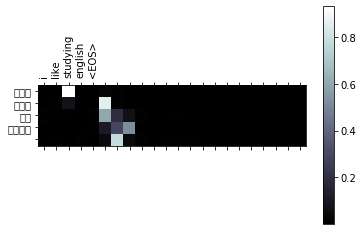

input = iron is harder than gold
output = मैं उसके में में में 


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2313 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 2313 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0, flags=flags)


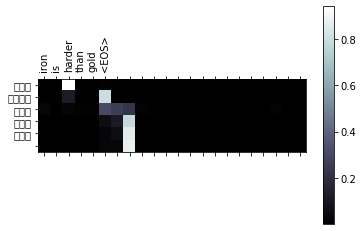

KeyError: ignored

In [46]:
def showAttention(input_sentence, output_words, attentions):
    %matplotlib inline
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("have fun")

evaluateAndShowAttention("i like studying english")

evaluateAndShowAttention("iron is harder than gold")

evaluateAndShowAttention("don't forget the srijan")